# Model Training
Welcome to the 'Model Training and Prediction' notebook, a crucial facet of our project's data science pipeline. In this notebook, we offer a meticulous examination of our rigorous model development process. The pipeline starts by accepting training data, followed by fitting three distinct types of models to it: Random Forest, Gradient Boosted Tree, and XGBoost. The initial stages include encoding categorical variables and executing Recursive Feature Elimination (RFE) for feature selection. This is succeeded by the application of genetic algorithms to hyperparameter tuning, operating in tandem with a cross-validation routine. Subsequently, the best model is selected based on the highest F1 score, indicating the balance between precision and recall. Finally, the selected model is utilized to predict the outcomes for the current week's round of NRL matches. This process is iterative and cyclical, with the potential for revisiting earlier stages based on the model's performance. Let us proceed with this in-depth exploration.

## Set up Environment
This code segment is setting up the environment for the model training pipeline. It begins by importing sys and pathlib - Python libraries used for managing system parameters and file paths, respectively.

The code then updates the system path to include the "functions" directory. This allows for the import of custom modules `modelling_functions`, `model_properties`, and `training_config` which are stored in this directory. These modules contain custom functions and configuration settings that are critical for the later stages of data preprocessing, model training, and prediction.

Following this, the `project_root` variable is defined. This is achieved by using the pathlib library to establish the root directory of the project.

Finally, the `db_path` variable is constructed. This is the relative path to the SQLite database "footy-tipper-db.sqlite", which is located in the "data" directory of the project root. This path will be used for database connectivity throughout the pipeline.

In [1]:
# import libraries
import os
import sys
import pathlib

cwd = os.getcwd()

# get the parent directory
parent_dir = os.path.dirname(cwd)

# add the parent directory to the system path
sys.path.insert(0, parent_dir)

# Get to the root directory
project_root = pathlib.Path().absolute().parent

# import functions from common like this:
from pipeline.common.model_training import (
    training_config as tc,
    modelling_functions as mf,
    model_properties as mp
)

from pipeline.common.model_prediciton import prediction_functions as pf

## Get data
Our process starts by establishing the root directory of the project and constructing the relative path to the 'footy-tipper-db.sqlite' database located within the 'data' directory. We then connect to this SQLite database and use a SQL query housed in the 'footy_tipping_data.sql' file, found in the 'sql' directory, to extract the required data. This data is loaded into a pandas DataFrame, footy_tipping_data, serving as the basis for our subsequent modeling activities. Upon successful extraction of the data, we ensure the database connection is closed, maintaining good coding practice and resource management.

In [2]:
data = mf.get_training_data(
    db_path = project_root / "data" / "footy-tipper-db.sqlite", 
    sql_file = project_root / 'pipeline/common/sql/training_data.sql')

data

,game_id,round_id,round_name,game_number,game_state_name,start_time,start_time_utc,venue_name,city,crowd,...,away_prev_result_diff,prev_result_diff,home_elo,away_elo,elo_diff,home_elo_prob,away_elo_prob,elo_draw_prob,elo_prob_diff,home_ground_advantage
0,2.018111e+10,1.0,Round 1,1.0,Final,1.520540e+09,1.520500e+09,Netstrata Jubilee Stadium,Sydney,14457.0,...,0.0,0.0,1498.871776,1510.436561,-11.564785,0.467857,0.492421,0.039722,-0.024564,3.493947
1,2.018111e+10,1.0,Round 1,2.0,Final,1.520618e+09,1.520579e+09,McDonald Jones Stadium,Newcastle,23516.0,...,0.0,0.0,1484.766828,1496.167248,-11.400420,0.468084,0.492194,0.039722,-0.024110,6.932228
2,2.018111e+10,1.0,Round 1,3.0,Final,1.520622e+09,1.520586e+09,1300SMILES Stadium,Townsville,15900.0,...,0.0,0.0,1506.226230,1503.248120,2.978110,0.487951,0.472327,0.039722,0.015624,0.955843
3,2.018111e+10,1.0,Round 1,4.0,Final,1.520699e+09,1.520660e+09,Accor Stadium,Sydney,18243.0,...,0.0,0.0,1493.848754,1500.976808,-7.128054,0.473986,0.486292,0.039722,-0.012306,-2.978035
4,2.018111e+10,1.0,Round 1,5.0,Final,1.520698e+09,1.520669e+09,Other,Perth,38824.0,...,0.0,0.0,1490.493737,1483.488252,7.005485,0.493514,0.466764,0.039722,0.026750,4.315751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1317,2.024111e+10,18.0,Round 18,4.0,Final,1.720278e+09,1.720242e+09,Accor Stadium,Sydney,27223.0,...,60.0,-59.0,1511.360142,1488.692560,22.667582,0.521733,0.450911,0.027356,0.070822,1.936236
1318,2.024111e+10,18.0,Round 18,5.0,Final,1.720287e+09,1.720251e+09,Leichhardt Oval,Sydney,10311.0,...,-6.0,30.0,1457.994294,1528.130944,-70.136650,0.400985,0.591264,0.007752,-0.190279,-8.892546
1319,2.024111e+10,18.0,Round 18,6.0,Final,1.720294e+09,1.720258e+09,Queensland Country Bank Stadium,Townsville,18787.0,...,14.0,-44.0,1502.064761,1506.824271,-4.759509,0.477259,0.483019,0.039722,-0.005761,1.101418
1320,2.024111e+10,18.0,Round 18,7.0,Final,1.720361e+09,1.720325e+09,Allianz Stadium,Sydney,23388.0,...,16.0,18.0,1551.887506,1501.545036,50.342470,0.565786,0.416973,0.017241,0.148813,12.045402


## Modelling

During the modeling phase, the `train_and_select_best_model` function, part of our `modelling_functions` module, is invoked. This function initiates the training of Poisson models specifically designed for predicting the scores of the home and away teams. It takes as input the footy tipping data, predictor variables, the outcome variable, and several configuration settings like whether to use Recursive Feature Elimination (RFE), the number of cross-validation folds, and the optimization metric, all sourced from the `training_config` module.

The function first identifies categorical columns in the feature set for one-hot encoding, creating dummy variables for categorical features. Depending on the choice of using RFE, a feature elimination step may be included in the pipeline. Each model subsequently undergoes hyperparameter tuning using a genetic algorithm, facilitated by the `GASearchCV` function.

All the models are then trained and evaluated through cross-validation. The best models for predicting home and away scores are selected based on superior performance on the chosen optimization metric. The selected models, encapsulated in pipelines with pre-processing steps and hyperparameter tuning, are now ready for the prediction phase.

The trained models are saved using the `save_models` function for future use, ensuring that the prediction process can be efficiently replicated and scaled.

### Test Modelling Data Preparation
First, because we want to understand how effective our simulations are without creating more load on the model cross-validation, we will split the data into training and testing sets. This will allow us to evaluate the model's interaction with each other on unseen data more easily.

In [3]:
# Set the random seed for reproducibility
random_seed = 42

# Define the test size proportion
test_size = 0.2

# Randomly shuffle the DataFrame and split
training_data = data.sample(frac=1 - test_size, random_state=random_seed)
test_data = data.drop(training_data.index)

### Poisson Modelling
The Poisson model is a statistical model that is used to predict the number of events occurring within a fixed interval of time or space. In the context of sports, the Poisson model can be used to predict the number of goals or points scored by each team in a match. In this section, we will implement a Poisson model to predict the number of points scored by each team in a match. We will then use these predictions to calculate the expected match outcome.

In [4]:
home_model = mf.train_and_select_best_model(
    training_data, tc.predictors, 'team_final_score_home',
    tc.use_rfe, tc.num_folds, tc.opt_metric
)
home_model


Model training: XGBRegressor
gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	100   	-13.8386	22.8868    	-5.86712   	-202.936   
1  	128   	-7.42067	1.05372    	-5.83151   	-11.3661   
2  	138   	-6.6926 	0.500704   	-5.83151   	-8.78594   
3  	134   	-6.30304	0.318171   	-5.79748   	-7.04887   
4  	146   	-6.05151	0.239581   	-5.66747   	-6.63385   
5  	130   	-5.88447	0.150478   	-5.66747   	-6.36172   
6  	140   	-5.78252	0.069974   	-5.66747   	-6.11864   
7  	138   	-5.74916	0.0703317  	-5.66747   	-6.16975   
8  	144   	-5.72525	0.10057    	-5.63935   	-6.67758   
9  	149   	-5.69392	0.0298937  	-5.63661   	-5.76107   
10 	141   	-5.67004	0.0250322  	-5.63661   	-5.76815   
11 	133   	-5.65368	0.0178989  	-5.62688   	-5.74314   
12 	145   	-5.64622	0.017978   	-5.62688   	-5.7431    
13 	138   	-5.63769	0.0100075  	-5.62423   	-5.69763   
14 	147   	-5.63189	0.0050902  	-5.62524   	-5.64188   
15 	140   	-5.62809	0.00255261 	-5.62237   	-5.63935   
16 	136   	-5.6263

Pipeline(steps=[('one_hot_encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['round_name', 'venue_name',
                                                   'city', 'team_home',
                                                   'team_away',
                                                   'broadcast_channel1',
                                                   'broadcast_channel2',
                                                   'broadcast_channel3',
                                                   'game_day'])])),
                ('hyperparamtuning',
                 GASearchCV(crossover_probability=0.5,
                            estimator=XGBRe...
                                        'learning_rate': <sklearn_genetic.space.space.Continuous object at 0x106df1850>,
                                        'max_depth': <sklearn_genetic.space.space.Integer object at 0x174da6a90>,
                                        'n_estimators': <sklearn_genetic.space.space.Integer object at 0x1749bb190>,
                                        'subsample': <sklearn_genetic.space.space.Continuous object at 0x174c8b310>},
                            population_size=100, return_train_score=True,
                            scoring=make_scorer(mean_poisson_deviance, greater_is_better=False)))])

In [5]:
away_model = mf.train_and_select_best_model(
    training_data, tc.predictors, 'team_final_score_away',
    tc.use_rfe, tc.num_folds, tc.opt_metric
)
away_model


Model training: XGBRegressor
gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	100   	-20.7577	99.9373    	-5.47027   	-1008.72   
1  	133   	-7.12727	1.05695    	-5.42169   	-10.4879   
2  	143   	-6.27207	0.624868   	-5.38032   	-8.26372   
3  	142   	-5.80458	0.442535   	-5.23917   	-7.03921   
4  	145   	-5.50468	0.227664   	-5.2217    	-6.444     
5  	131   	-5.35999	0.0807167  	-5.2217    	-5.62557   
6  	146   	-5.29869	0.0642133  	-5.2217    	-5.47076   
7  	134   	-5.25543	0.0401656  	-5.2217    	-5.41879   
8  	139   	-5.23428	0.0240109  	-5.21953   	-5.36376   
9  	153   	-5.22555	0.017067   	-5.21953   	-5.38595   
10 	144   	-5.2226 	0.00398814 	-5.21953   	-5.23917   
11 	153   	-5.22159	0.000473902	-5.21953   	-5.2217    
12 	135   	-5.2214 	0.000754493	-5.21953   	-5.2217    
13 	137   	-5.22109	0.000976308	-5.21953   	-5.2217    
14 	137   	-5.2205 	0.00108176 	-5.21953   	-5.2217    
15 	149   	-5.21979	0.0007066  	-5.21953   	-5.2217    
16 	141   	-5.2195

Pipeline(steps=[('one_hot_encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['round_name', 'venue_name',
                                                   'city', 'team_home',
                                                   'team_away',
                                                   'broadcast_channel1',
                                                   'broadcast_channel2',
                                                   'broadcast_channel3',
                                                   'game_day'])])),
                ('hyperparamtuning',
                 GASearchCV(crossover_probability=0.5,
                            estimator=XGBRe...
                                        'learning_rate': <sklearn_genetic.space.space.Continuous object at 0x174fa3c90>,
                                        'max_depth': <sklearn_genetic.space.space.Integer object at 0x174fa0c90>,
                                        'n_estimators': <sklearn_genetic.space.space.Integer object at 0x173dd3450>,
                                        'subsample': <sklearn_genetic.space.space.Continuous object at 0x174fa2cd0>},
                            population_size=100, return_train_score=True,
                            scoring=make_scorer(mean_poisson_deviance, greater_is_better=False)))])

### Example simulation of a match
In this section, we will simulate a match between two teams using the Poisson model. We will generate the expected number of points scored by each team and use these predictions to determine the match outcome. We will then compare the predicted outcome with the actual outcome to evaluate the accuracy of the Poisson model.

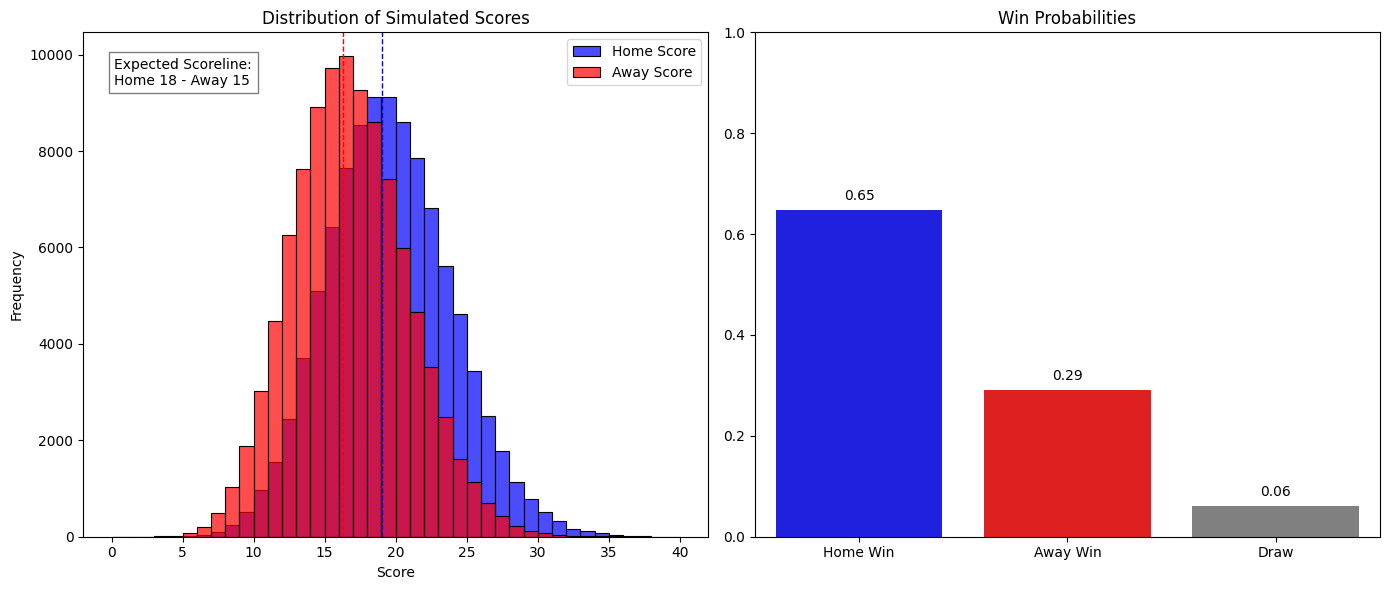

In [6]:
# Example usage with test_data
mp.plot_sampling_distributions(home_model, away_model, test_data, tc.predictors)

###  Evaluation
The evaluation phase involves predicting the outcomes of an unseen set of random NRL matches using the selected home and away models.

This section is only to be used in development and testing at the moment.

Accuracy: 0.71

Classification Report:
              precision    recall  f1-score   support

    home_win       0.72      0.81      0.76       150
    away_win       0.70      0.59      0.64       114
        draw       0.00      0.00      0.00         0

   micro avg       0.71      0.71      0.71       264
   macro avg       0.47      0.46      0.47       264
weighted avg       0.71      0.71      0.71       264



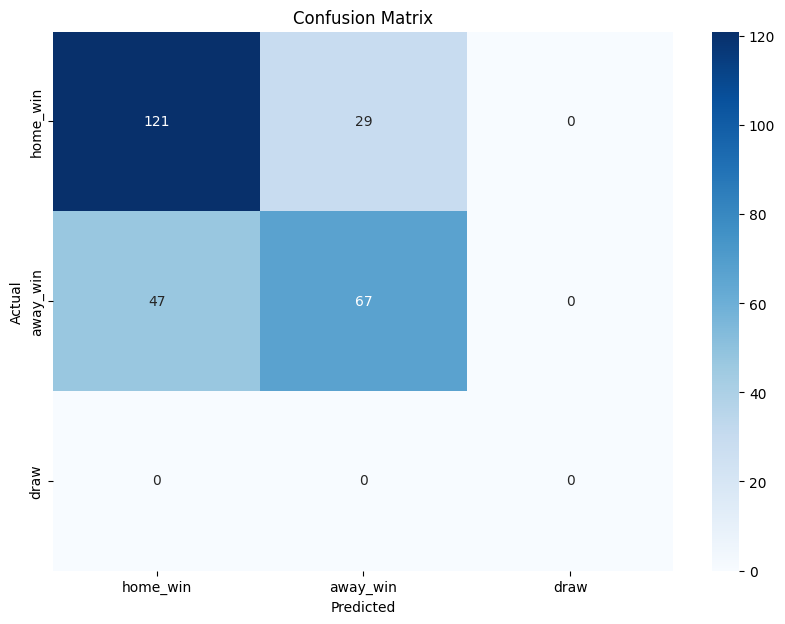

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


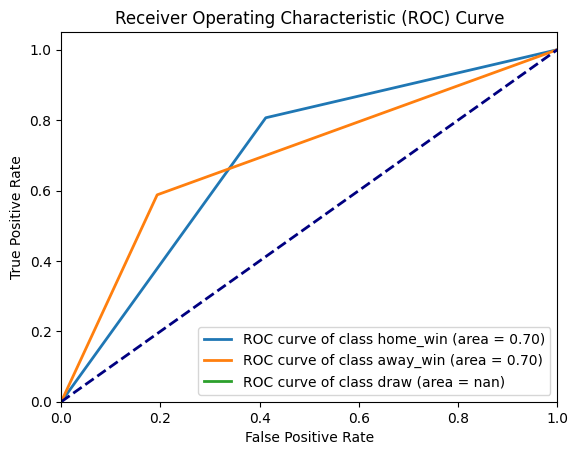

In [7]:
# Evaluate the models on the test data
result_df = mp.evaluate_models(home_model, away_model, test_data, tc.predictors)

#### Feature importance
The `get_feature_importance` function retrieves feature importances from a trained scikit-learn pipeline. It accounts for different transformations, such as one-hot encoding and recursive feature elimination. The function then returns a sorted DataFrame listing each feature alongside its respective importance, aiding in understanding the model's decision-making process.

In [8]:
# feature_importance_df = mp.get_feature_importances_from_pipeline(footy_tipper, tc.predictors)
# feature_importance_df

## Save Models
The `save_models` function stores Pipeline objects to the disk. This allows for easy retrieval and reuse in future model prediction tasks, without the need to retrain these components. The objects are stored in a designated 'models' directory under the project root path, ensuring organized and consistent storage.

In [9]:
mf.save_models(home_model, 'home_model', project_root)
mf.save_models(away_model, 'away_model', project_root)

Pipeline saved to models/home_model.pkl
Pipeline saved to models/away_model.pkl


## Match Simulation and Prediction
The final stage of the pipeline involves predicting the outcomes of the current week's NRL matches. This is achieved by loading the saved models from the 'models' directory and utilizing them to simulate the matches. The predictions are then stored in a DataFrame, which is subsequently written back to the SQLite database. This data can be accessed by the front-end application to display the predicted outcomes to the users.

In [10]:
# Load the models
home_model = pf.load_models('home_model', project_root)
away_model = pf.load_models('away_model', project_root)

# Load this week's game data
inference_data = pf.get_inference_data(
    db_path = project_root / "data" / "footy-tipper-db.sqlite", 
    sql_file = project_root / 'pipeline/common/sql/inference_data.sql')
inference_data

home_model model pipeline loaded
away_model model pipeline loaded
Getting inference data...


,game_id,round_id,round_name,game_number,game_state_name,start_time,start_time_utc,venue_name,city,crowd,...,away_prev_result_diff,prev_result_diff,home_elo,away_elo,elo_diff,home_elo_prob,away_elo_prob,elo_draw_prob,elo_prob_diff,home_ground_advantage
0,2.024111e+10,19.0,Round 19,1.0,Pre Game,1.720727e+09,1.720691e+09,Kayo Stadium,Redcliffe,None,...,-16.0,10.0,1496.657139,1497.037817,-0.380677,0.483310,0.476968,0.039722,0.006342,1.724033
1,2.024111e+10,19.0,Round 19,2.0,Pre Game,1.720814e+09,1.720778e+09,PointsBet Stadium,Sydney,None,...,34.0,-38.0,1508.923252,1459.456087,49.467165,0.558765,0.413879,0.027356,0.144886,8.692100
2,2.024111e+10,19.0,Round 19,3.0,Pre Game,1.720892e+09,1.720856e+09,Cbus Super Stadium,Gold Coast,None,...,8.0,52.0,1495.658494,1467.378022,28.280473,0.529538,0.443106,0.027356,0.086432,4.349967
3,2.024111e+10,19.0,Round 19,4.0,Pre Game,1.720899e+09,1.720863e+09,Suncorp Stadium,Brisbane,None,...,30.0,-38.0,1499.044636,1493.719869,5.324768,0.491193,0.469085,0.039722,0.022107,5.434833
4,2.024111e+10,19.0,Round 19,5.0,Pre Game,1.720973e+09,1.720937e+09,4 Pines Park,Sydney,None,...,-4.0,20.0,1507.051811,1490.883753,16.168058,0.512672,0.459972,0.027356,0.052700,3.792200


### Prediction Simulation
The `simulate_predictions` function is used to predict the outcomes of the current week's NRL matches. It loads the saved models from the 'models' directory and uses them to simulate the matches. The predictions are then stored in a DataFrame, which is written back to the SQLite database.

In [11]:
import pandas as pd

# Predict match outcomes and scorelines for the inference data
outcomes, margins = pf.predict_match_outcome_and_scoreline(home_model, away_model, inference_data, tc.predictors)
pd.merge(outcomes, margins, on='game_id')

# Save the predictions to the database
pf.save_predictions_to_db(
    outcomes, 
    project_root / "data" / "footy-tipper-db.sqlite", 
    project_root / 'pipeline/common/sql/create_table.sql', 
    project_root / 'pipeline/common/sql/insert_into_table.sql'
)

Saving predictions to database...


## Sending Predictions via Email using ChatGPT
In this section, we will use the OpenAI ChatGPT model to generate an email template for sending the predictions to the users. We will use the predictions generated in the previous section and the ChatGPT model to create a personalized email template for each user. The email template will contain the predicted outcomes of the NRL matches for the current week.

In [12]:
from dotenv import load_dotenv
from pipeline.common.model_prediciton import prediction_functions as pf
from pipeline.common.use_predictions import sending_functions as sf

# Now construct the relative path to your SQLite database
db_path = project_root / "data" / "footy-tipper-db.sqlite"
secrets_path = project_root / "secrets.env"
json_path = project_root / "service-account-token.json"

load_dotenv(dotenv_path=secrets_path)

True

In [13]:
import sqlite3
import pandas as pd
# Connect to the SQLite database
con = sqlite3.connect(str(db_path))

# Read SQL query from external SQL file
with open(project_root / 'pipeline/common' / 'sql/prediction_table.sql', 'r') as file:
    query = file.read()

# Execute the query and fetch the results into a data frame
predictions = pd.read_sql_query(query, con)

# Disconnect from the SQLite database
con.close()

predictions

,game_id,home_team_result,team_home,position_home,team_head_to_head_odds_home,team_away,position_away,team_head_to_head_odds_away,home_team_win_prob,home_team_lose_prob,round_id,competition_year,round_name
0,20241111910,Win,Dolphins,6,1.68,South Sydney Rabbitohs,13,2.18,0.64006,0.30381,19,2024,Round 19
1,20241111920,Win,Cronulla-Sutherland Sharks,4,1.46,Wests Tigers,17,2.71,0.90866,0.06903,19,2024,Round 19
2,20241111930,Win,Gold Coast Titans,15,1.43,Parramatta Eels,16,2.84,0.92477,0.05598,19,2024,Round 19
3,20241111940,Loss,Brisbane Broncos,11,1.47,St. George Illawarra Dragons,10,2.68,0.42400,0.51761,19,2024,Round 19
4,20241111950,Win,Manly-Warringah Sea Eagles,7,1.39,Newcastle Knights,9,3.00,0.68046,0.26686,19,2024,Round 19


### Tippper Picks
The Tipper Picks are selcted games which show high value for the tipper to select. This is based on the predicted outcomes of the matches and the odds of the games.

This shows how predictions can be used to further enrich the user experience and provide valuable insights to the users.

In [14]:
tipper_picks = sf.get_tipper_picks(predictions)
tipper_picks

,team,price,price_min
0,Dolphins,1.68,1.562354
1,Cronulla-Sutherland Sharks,1.46,1.100522
2,Gold Coast Titans,1.43,1.081350
3,St. George Illawarra Dragons,2.68,1.931956


In [15]:
# sf.upload_df_to_drive(
#     predictions, 
#     json_path, 
#     os.getenv('FOLDER_ID'), 
#     "predictions.csv"
# )

### Reg Reagan's Email
In this section, we will generate an email from Reg Reagan, a fictional character, using the OpenAI ChatGPT model. The email will contain the predicted outcomes of the NRL matches for the current week, along with some humorous and engaging content. The email will be sent to the users to provide them with the predictions and entertain them at the same time.

In [16]:
reg_reagan = sf.generate_reg_regan_email(
    predictions, 
    tipper_picks, 
    os.getenv('OPENAI_KEY'), 
    os.getenv('FOLDER_URL'),
    1
)

print(reg_reagan)

Subject: Reg's Round 19 Tips: May the Odds Be in Your Favor

Ahoy, punters!

Time to strap on the footy boots, pull up the socks, and invest some money in some good, old-fashioned rugby league banter. Reg has once again conjured up his predictions for the NRL Round 19 games, and they are hotter than a sausage roll from the local footy pie stand.

Have a gander here, and may the footy gods bless your every gamble: https://drive.google.com/drive/u/1/folders/1lT1SQH-kQPdnOf3ftomobuiv51jEj6t-

First up, the Dolphins are tipped for a win against the South Sydney Rabbitohs. Ah, the Dolphins - Riding the wave into 6th, all seems to be going swimmingly for them. On the flip side, the Rabbitohs hopped their way down to 13th. Not too promising, eh?

Next, the Toothless Tigers will face the mighty Sharks. At sea level, the Sharks in 4th are circling the poor Tigers in dead last. Sink or swim, lads!

The Gold Coast Titans are looking to get their hands dirty against the Eels. Looks like the Titans

In [17]:
# sf.send_emails(
#     "footy-tipper-email-list", 
#     f"Footy Tipper Predictions for {predictions['round_name'].unique()[0]}", 
#     reg_reagan, 
#     os.getenv('MY_EMAIL'), 
#     os.getenv('EMAIL_PASSWORD'), 
#     json_path
# )